In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3
from tqdm import tqdm
import time 
import pickle
import networkx as nx
import random as rn

from datetime import datetime
from datetime import timedelta

from create_financial_database import get_credentials 
from SQLite_tools import query_stock_data, check_if_close_price_exists
from ticker_loader import load_SPY_components
from pyvis.network import Network

In [2]:
# date = "2023-04-18"
# date = "2014-04-09"
# date = "2014-01-17"

pickle_file = f'../Data/Edges/correlation_short_term.pkl'

with open(pickle_file, 'rb') as f:
    all_edges_dict = pickle.load(f)
    
    
print("all_edges_dict.keys(): ", all_edges_dict.keys())

all_edges_dict.keys():  dict_keys(['1996-03-04', '1996-03-05', '1996-03-06', '1996-03-07', '1996-03-08', '1996-03-11', '1996-03-12', '1996-03-13', '1996-03-14', '1996-03-15', '1996-03-18', '1996-03-19', '1996-03-20', '1996-03-21', '1996-03-22', '1996-03-25', '1996-03-26', '1996-03-27', '1996-03-28', '1996-03-29', '1996-04-01', '1996-04-02', '1996-04-03', '1996-04-04', '1996-04-08', '1996-04-09', '1996-04-10', '1996-04-11', '1996-04-12', '1996-04-15', '1996-04-16', '1996-04-17', '1996-04-18', '1996-04-19', '1996-04-22', '1996-04-23', '1996-04-24', '1996-04-25', '1996-04-26', '1996-04-29', '1996-04-30', '1996-05-01', '1996-05-02', '1996-05-03', '1996-05-06', '1996-05-07', '1996-05-08', '1996-05-09', '1996-05-10', '1996-05-13', '1996-05-14', '1996-05-15', '1996-05-16', '1996-05-17', '1996-05-20', '1996-05-21', '1996-05-22', '1996-05-23', '1996-05-24', '1996-05-28', '1996-05-29', '1996-05-30', '1996-05-31', '1996-06-03', '1996-06-04', '1996-06-05', '1996-06-06', '1996-06-07', '1996-06-10',

In [4]:
date = "2019-04-18"

specific_dict = all_edges_dict[date]
print("specific_dict size: ", len(specific_dict))

print(specific_dict.keys())

specific_dict size:  1849
dict_keys([('CPAY', 'FLT'), ('FI', 'FISV'), ('DISCA', 'WBD'), ('ANTM', 'ELV'), ('FB', 'META'), ('ABC', 'COR'), ('RTX', 'UTX'), ('HRS', 'LHX'), ('PKI', 'RVTY'), ('CBS', 'VIAC'), ('J', 'JEC'), ('CBS', 'PARA'), ('PARA', 'VIAC'), ('BBT', 'TFC'), ('ARNC', 'HWM'), ('BHGE', 'BKR'), ('COG', 'CTRA'), ('GL', 'TMK'), ('NLOK', 'SYMC'), ('GEN', 'SYMC'), ('CTL', 'LUMN'), ('GEN', 'NLOK'), ('WLTW', 'WTW'), ('GOOG', 'GOOGL'), ('DD', 'DWDP'), ('CFG', 'ZION'), ('PAYX', 'V'), ('FDC', 'FI'), ('FDC', 'FISV'), ('DISCK', 'WBD'), ('DISCA', 'DISCK'), ('MCO', 'SPGI'), ('TFC', 'ZION'), ('BBT', 'ZION'), ('CPAY', 'ROP'), ('FLT', 'ROP'), ('CSCO', 'ECL'), ('CFG', 'FHN'), ('CMA', 'ZION'), ('G', 'VRSK'), ('DTE', 'DTV'), ('ANET', 'PYPL'), ('G', 'SNPS'), ('EFX', 'IT'), ('G', 'MKC'), ('HBAN', 'PBCT'), ('HBAN', 'RF'), ('NTAP', 'XRX'), ('FHN', 'ZION'), ('HON', 'MCO'), ('ANET', 'MA'), ('RF', 'SIVB'), ('CDNS', 'GPN'), ('FDS', 'MSCI'), ('ADP', 'ROP'), ('ROP', 'VRSK'), ('ACN', 'G'), ('ARE', 'MAA'), ('C

In [5]:
active_stocks = query_stock_data(table="Active_Stocks", ticker= "all_stocks", start_date = date, end_date = date)
active_stocks = active_stocks[active_stocks["Active"] == 1]

feature_set  = query_stock_data(table="ML_Feature_Table", ticker= "all_stocks", start_date=date, end_date=date)
invert_stats = query_stock_data(table="Standardized_Fundamental_Data", ticker= "all_stocks")
invert_stats = invert_stats[invert_stats["Date"] >= date[:7]]
invert_stats = invert_stats[invert_stats["Feature"] == "Cbrt_TotalRevenue"].reset_index(drop=True)
invert_stats = invert_stats.loc[0]

feature_set = feature_set[feature_set["Active"] == 1]
feature_set = feature_set[["Date", "Ticker", "Cbrt_TotalRevenue"]]
feature_set["Cbrt_TotalRevenue"] = feature_set["Cbrt_TotalRevenue"] * invert_stats["Std"] + invert_stats["Mean"]

feature_set = pd.merge(feature_set, active_stocks , on="Ticker", how="left")
feature_set = feature_set[feature_set["Active"] == 1]
feature_set = feature_set[feature_set['Cbrt_TotalRevenue']>0] # removes one outlier
feature_set.describe()

,Cbrt_TotalRevenue,Active
count,489.00000000,489.00000000
mean,11.32062010,1.00000000
std,1.55510723,0.00000000
min,6.97352986,1.00000000
25%,10.24471618,1.00000000
50%,11.11949017,1.00000000
75%,12.11198607,1.00000000
max,17.33646540,1.00000000


In [34]:
feature_set.head()

,Date_x,Ticker,Cbrt_TotalRevenue,Date_y,Active
0,2019-04-18,RCL,11.01094438,2019-04-18,1.00000000
1,2019-04-18,WAT,9.64472556,2019-04-18,1.00000000
2,2019-04-18,AEE,10.41481099,2019-04-18,1.00000000
3,2019-04-18,HOLX,9.80823818,2019-04-18,1.00000000
4,2019-04-18,CSX,11.31750033,2019-04-18,1.00000000


node_sizes:  [50.66740949181597, 33.04896110456582, 45.26333114115738, 37.99728270052107, 53.29754417380052, 45.375804166207075, 65.46505995504074, 29.3293270723931, 42.42210661603721, 27.473416393096226, 52.28697666168628, 61.492279828873194, 52.028555536828094, 51.95509846262585, 46.00422802189108, 51.657356686166516, 37.02374396957141, 76.48880685870336, 42.30749749915624, 35.09963250300069, 45.98142413763077, 49.17167956678014, 40.227116958846345, 59.74863651190523, 42.01856130698681, 43.25042078978811, 77.65227199684226, 36.91250616381963, 42.18761783707593, 63.489279070410625, 62.96437959683928, 51.49934259689621, 44.24601031871758, 40.219317525926606, 47.77712461069305, 52.21053323839642, 36.62260044094788, 43.902852055089824, 60.858693145505214, 70.61449329065162, 55.64989049641318, 72.75465107339971, 81.0700150595977, 39.554115964036534, 51.69023243643301, 59.81946375250105, 67.6150606772505, 52.16072403560457, 33.73617931200263, 52.80788827823265, 35.49511912735548, 49.514335

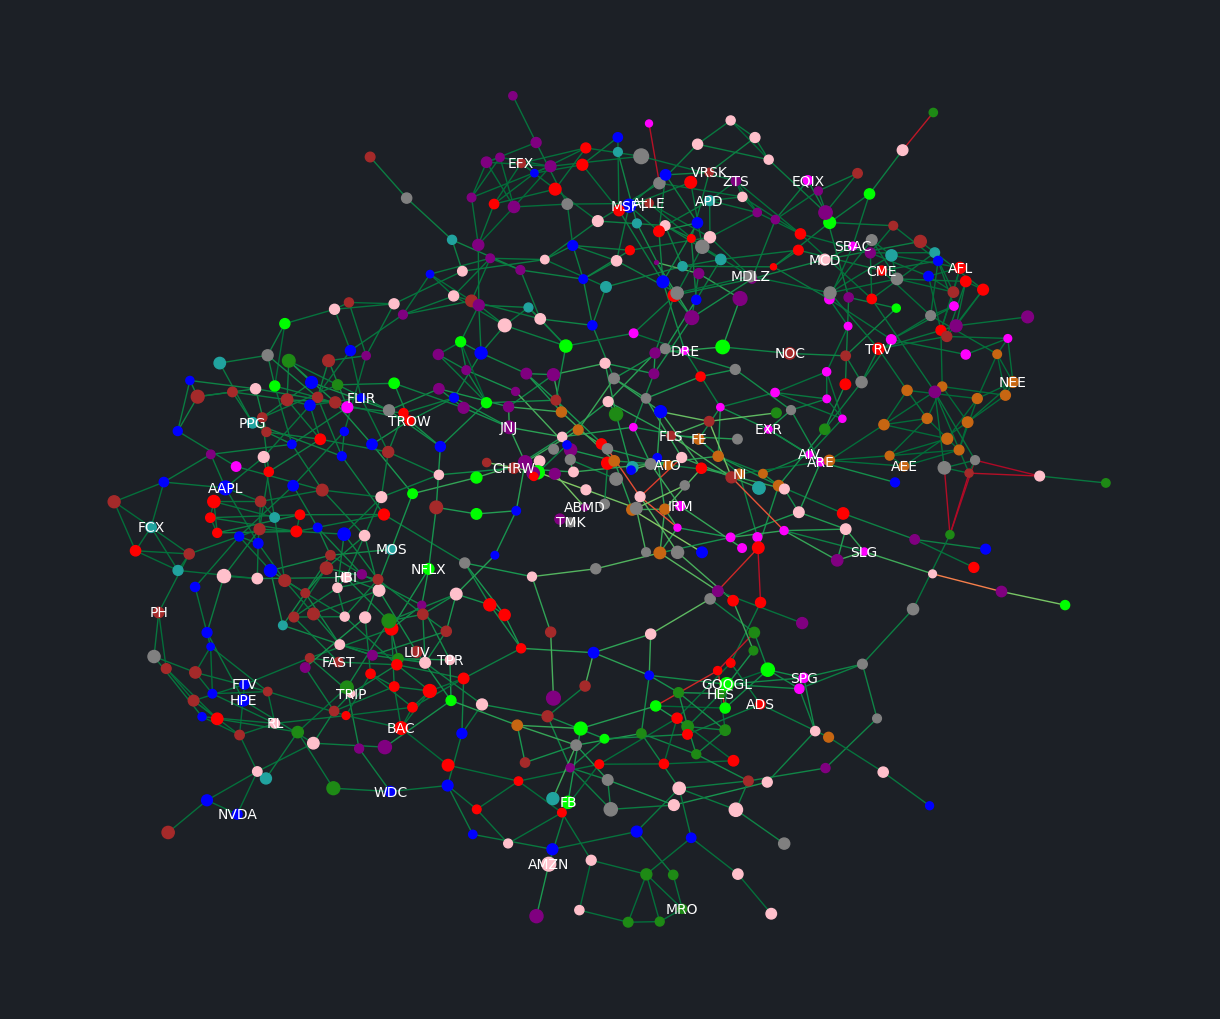

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
import numpy as np

def create_network_viz(date: str, edges_dict: dict, seed: int = 1, first_date = True):

    if len(date) == 7:
        if first_date:
            tmp_data = query_stock_data(table="Target_Data", ticker= "BAC", start_date = date+"-01", end_date = date+"-31")
            date = tmp_data["Date"].values[0]
        else:
            tmp_data = query_stock_data(table="Target_Data", ticker= "BAC", start_date = date+"-01", end_date = date+"-31")
            date = tmp_data["Date"].values[12]

    stock_data = query_stock_data(table="Stocks", ticker= "all_stocks")
    active_stocks = query_stock_data(table="Active_Stocks", ticker= "all_stocks", start_date = date, end_date = date)
    active_stocks = active_stocks[active_stocks["Active"] == 1]

    feature_set  = query_stock_data(table="ML_Feature_Table", ticker= "all_stocks", start_date=date, end_date=date)
    invert_stats = query_stock_data(table="Standardized_Fundamental_Data", ticker= "all_stocks")
    invert_stats = invert_stats[invert_stats["Date"] >= date[:7]]
    invert_stats = invert_stats[invert_stats["Feature"] == "Cbrt_TotalRevenue"].reset_index(drop=True)
    invert_stats = invert_stats.loc[0]

    feature_set = feature_set[feature_set["Active"] == 1]
    feature_set = feature_set[["Date", "Ticker", "Cbrt_TotalRevenue"]]
    feature_set["Cbrt_TotalRevenue"] = feature_set["Cbrt_TotalRevenue"] * invert_stats["Std"] + invert_stats["Mean"]
    # feature_set["Cbrt_TotalRevenue"] = feature_set["Cbrt_TotalRevenue"] ** 2

    feature_set = pd.merge(feature_set, active_stocks , on="Ticker", how="left")
    feature_set = feature_set[feature_set["Active"] == 1]
    feature_set = feature_set[feature_set['Cbrt_TotalRevenue']>0] # removes one outlier

    end_date = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=1)
    end_date = end_date.strftime("%Y-%m-%d")

    G = nx.Graph()

    sector_colors = {
        1: 'pink', 2: '#52a80f', 3: '#1e8a15', 4: 'red', 5: 'purple',
        6: 'brown', 7: 'blue', 8: '#21a39f', 9: 'lime', 10: '#c76612',
        11: 'magenta', 12: 'grey'}

    sector_names = {
        1: 'Consumer Cyclical', 2: 'Consumer Staples', 3: 'Energy',
        4: 'Financials', 5: 'Healthcare', 6: 'Industrials',
        7: 'Technology', 8: 'Basic Materials', 9: 'Communication Services',
        10: 'Utilities', 11: 'Real Estate', 12: 'Other'
    }


    for idx,ticker in enumerate(feature_set["Ticker"]):
        G.add_node(ticker , name = ticker)
        # Defining the node color based on the sector (thought it was a good idea)
        sector = stock_data[stock_data["Ticker"] == ticker]["Sector"].values[0]
        if sector == 'Consumer Cyclical':
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(1)
        elif sector == "Consumer Staples":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(2)
        elif sector == "Energy":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(3)
        elif sector in ["Financials", "Financial", "Financial Services"]:
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(4)
        elif sector == "Healthcare":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(5)
        elif sector == "Industrials":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(6)
        elif sector == "Technology":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(7)
        elif sector == "Basic Materials":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(8)
        elif sector == "Communication Services":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(9)
        elif sector == "Utilities":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(10)
        elif sector == "Real Estate":
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(11)
        else:
            G.nodes[ticker]['Node_Sector'] =  sector_colors.get(12)

        G.nodes[ticker]['size'] = feature_set.loc[feature_set["Ticker"] == ticker, "Cbrt_TotalRevenue"].values[0]

    local_edges_dict = edges_dict[date]
    for (ticker_1, ticker_2), local_dict in local_edges_dict.items():
        correlation = local_dict['correlation']
        if not G.has_edge(ticker_1, ticker_2):
            if G.has_node(ticker_1) and G.has_node(ticker_2):
                G.add_edge(ticker_1, ticker_2, weight=correlation)

    # Remove nodes with no edges
    # G.remove_nodes_from(list(nx.isolates(G)))

    plt.figure(figsize=(12, 10), facecolor='grey')
    # pos = nx.spring_layout(G, weight='weight', seed=seed, iterations=50)
    
    # Node properties
    node_colors = [G.nodes[n]['Node_Sector'] for n in G.nodes]
    node_sizes = [
        ((G.nodes[n]['size']-6)*10)  # Scale sizes for better visibility
        for n in G.nodes
    ]

    print("node_sizes: ", node_sizes)

    # Edge properties
    edge_weights = [G.edges[e]['weight'] for e in G.edges]
    edge_colors = [
        plt.cm.RdYlGn(Normalize(vmin=0, vmax=1)(w)) for w in edge_weights
    ]

    pos = nx.kamada_kawai_layout(G, weight= None)

    labels = {}
    for node in G.nodes():
        if node in ["BAC", "GME", "META", "NVDA", "AAPL", "TSLA", "MSFT", "GOOGL", "AMZN", "FB", "NFLX"]:
            labels[node] = node
        else:
            random_num = rn.randint(0, 100)
            if random_num > 90:
                labels[node] = node
            
    nx.draw(
        G,
        pos,
        with_labels=True,
        labels= labels,
        font_size=10,
        node_color=node_colors,
        edge_color=edge_colors,
        node_size=node_sizes,
        font_color='white',
        width=1
    )

    plt.gcf().set_facecolor('#1c2026')
    # plt.gcf().set_facecolor('White')
    
    plt.savefig(f'../Data/Network_Images/Network_{date}.png', facecolor='#1c2026')
    # plt.savefig(f'../Data/Network_Images/Network_{date}.png', facecolor='White')

    plt.show()

    return G


date = "2020-03"
date = "2019-07"
G = create_network_viz(date=date, edges_dict=all_edges_dict, seed=9, first_date=True)


# for year in tqdm(range(1997, 2025)):
#     for month in range(1, 13):
#         date = f"{year}-{month:02d}"
#         # if date in all_edges_dict.keys():
#         G = create_network_viz(date=date, edges_dict=all_edges_dict, seed=9, first_date=True)
#         G = create_network_viz(date=date, edges_dict=all_edges_dict, seed=9, first_date=False)


In [ ]:
def create_network_viz_pyviz(date: str, edges_dict: dict, seed: int = 1, first_date=True):
    if len(date) == 7:
        if first_date:
            tmp_data = query_stock_data(table="Target_Data", ticker="BAC", start_date=date+"-01", end_date=date+"-31")
            date = tmp_data["Date"].values[0]
        else:
            tmp_data = query_stock_data(table="Target_Data", ticker="BAC", start_date=date+"-01", end_date=date+"-31")
            date = tmp_data["Date"].values[12]

    stock_data = query_stock_data(table="Stocks", ticker="all_stocks")
    active_stocks = query_stock_data(table="Active_Stocks", ticker="all_stocks", start_date=date, end_date=date)
    active_stocks = active_stocks[active_stocks["Active"] == 1]

    feature_set = query_stock_data(table="ML_Feature_Table", ticker="all_stocks", start_date=date, end_date=date)
    invert_stats = query_stock_data(table="Standardized_Fundamental_Data", ticker="all_stocks")
    invert_stats = invert_stats[invert_stats["Date"] >= date[:7]]
    invert_stats = invert_stats[invert_stats["Feature"] == "Cbrt_TotalRevenue"].reset_index(drop=True)
    invert_stats = invert_stats.loc[0]

    feature_set = feature_set[feature_set["Active"] == 1]
    feature_set = feature_set[["Date", "Ticker", "Cbrt_TotalRevenue"]]
    feature_set["Cbrt_TotalRevenue"] = feature_set["Cbrt_TotalRevenue"] * invert_stats["Std"] + invert_stats["Mean"]

    feature_set = pd.merge(feature_set, active_stocks, on="Ticker", how="left")
    feature_set = feature_set[feature_set["Active"] == 1]
    feature_set = feature_set[feature_set['Cbrt_TotalRevenue'] > 0]  # removes one outlier

    net = Network(height="1000px", width="1880px", bgcolor="#1c2026", font_color="white")
    net.barnes_hut(gravity=-5000, central_gravity=0.15, spring_length=100, spring_strength=0.001, damping=0.0001)

    sector_colors = {
        1: 'pink', 2: '#52a80f', 3: '#1e8a15', 4: 'red', 5: 'purple',
        6: 'brown', 7: 'blue', 8: '#21a39f', 9: 'lime', 10: '#c76612',
        11: 'magenta', 12: 'grey'}

    for idx, ticker in enumerate(feature_set["Ticker"]):
        sector = stock_data[stock_data["Ticker"] == ticker]["Sector"].values[0]
        node_color = sector_colors.get(
            {
                'Consumer Cyclical': 1, 'Consumer Staples': 2, 'Energy': 3,
                'Financials': 4, 'Healthcare': 5, 'Industrials': 6, 'Technology': 7,
                'Basic Materials': 8, 'Communication Services': 9, 'Utilities': 10,
                'Real Estate': 11
            }.get(sector, 12),
            'grey'
        )

        size = feature_set.loc[feature_set["Ticker"] == ticker, "Cbrt_TotalRevenue"].values[0]
        size_scaled = max(10, (size - 6) * 10)  

        net.add_node(
            ticker,
            label=ticker,
            title=f"{ticker}: {sector}",
            color=node_color,
            value=size_scaled
        )

    local_edges_dict = edges_dict[date]
    for (ticker_1, ticker_2), local_dict in local_edges_dict.items():
        correlation = local_dict['correlation']
        if ticker_1 in net.node_ids and ticker_2 in net.node_ids:
            edge_color = 'green' if correlation > 0.5 else 'red'
            edge_thickness = 10 * (0.5 - abs(correlation - 0.5))  # Smallest at 0.5, largest at 0 and 1
            net.add_edge(ticker_1, ticker_2, value=edge_thickness, color=edge_color)

    net.set_options('''{
    "nodes": {
        "shape": "sphere",
        "scaling": {
            "min": 3,
            "max": 20
        }
    },
    "edges": {
        "color": {
            "inherit": true
        },
        "smooth": false,
        "scaling": {
            "min": 1,
            "max": 5
        }
    },
    "physics": {
        "enabled": true
    },
    "layout": {
        "improvedLayout": true,
        "hierarchical": false
    }
    }''')

    output_file = f"../Data/Network_Images/Network_{date}.html"
    net.save_graph(output_file)
    print(f"Network graph saved as: {output_file}")

    return net

for year in tqdm(range(2020, 2025)):
    for month in range(1, 13):
        date = f"{year}-{month:02d}"
        create_network_viz_pyviz(date = date, edges_dict = all_edges_dict)


  0%|          | 0/5 [00:00<?, ?it/s]

Network graph saved as: ../Data/Network_Images/Network_2020-01-02.html
Network graph saved as: ../Data/Network_Images/Network_2020-02-03.html
Network graph saved as: ../Data/Network_Images/Network_2020-03-02.html
Network graph saved as: ../Data/Network_Images/Network_2020-04-01.html
Network graph saved as: ../Data/Network_Images/Network_2020-05-01.html
Network graph saved as: ../Data/Network_Images/Network_2020-06-01.html
Network graph saved as: ../Data/Network_Images/Network_2020-07-01.html
Network graph saved as: ../Data/Network_Images/Network_2020-08-03.html
Network graph saved as: ../Data/Network_Images/Network_2020-09-01.html
Network graph saved as: ../Data/Network_Images/Network_2020-10-01.html
Network graph saved as: ../Data/Network_Images/Network_2020-11-02.html


 20%|██        | 1/5 [00:04<00:19,  4.99s/it]

Network graph saved as: ../Data/Network_Images/Network_2020-12-01.html
Network graph saved as: ../Data/Network_Images/Network_2021-01-04.html
Network graph saved as: ../Data/Network_Images/Network_2021-02-01.html
Network graph saved as: ../Data/Network_Images/Network_2021-03-01.html
Network graph saved as: ../Data/Network_Images/Network_2021-04-01.html
Network graph saved as: ../Data/Network_Images/Network_2021-05-03.html
Network graph saved as: ../Data/Network_Images/Network_2021-06-01.html
Network graph saved as: ../Data/Network_Images/Network_2021-07-01.html
Network graph saved as: ../Data/Network_Images/Network_2021-08-02.html
Network graph saved as: ../Data/Network_Images/Network_2021-09-01.html
Network graph saved as: ../Data/Network_Images/Network_2021-10-01.html
Network graph saved as: ../Data/Network_Images/Network_2021-11-01.html


 40%|████      | 2/5 [00:10<00:15,  5.28s/it]

Network graph saved as: ../Data/Network_Images/Network_2021-12-01.html
Network graph saved as: ../Data/Network_Images/Network_2022-01-03.html
Network graph saved as: ../Data/Network_Images/Network_2022-02-01.html
Network graph saved as: ../Data/Network_Images/Network_2022-03-01.html
Network graph saved as: ../Data/Network_Images/Network_2022-04-01.html
Network graph saved as: ../Data/Network_Images/Network_2022-05-02.html
Network graph saved as: ../Data/Network_Images/Network_2022-06-01.html
Network graph saved as: ../Data/Network_Images/Network_2022-07-01.html
Network graph saved as: ../Data/Network_Images/Network_2022-08-01.html
Network graph saved as: ../Data/Network_Images/Network_2022-09-01.html
Network graph saved as: ../Data/Network_Images/Network_2022-10-03.html
Network graph saved as: ../Data/Network_Images/Network_2022-11-01.html


 60%|██████    | 3/5 [00:15<00:10,  5.26s/it]

Network graph saved as: ../Data/Network_Images/Network_2022-12-01.html
Network graph saved as: ../Data/Network_Images/Network_2023-01-03.html
Network graph saved as: ../Data/Network_Images/Network_2023-02-01.html
Network graph saved as: ../Data/Network_Images/Network_2023-03-01.html
Network graph saved as: ../Data/Network_Images/Network_2023-04-03.html
Network graph saved as: ../Data/Network_Images/Network_2023-05-01.html
Network graph saved as: ../Data/Network_Images/Network_2023-06-01.html
Network graph saved as: ../Data/Network_Images/Network_2023-07-03.html
Network graph saved as: ../Data/Network_Images/Network_2023-08-01.html
Network graph saved as: ../Data/Network_Images/Network_2023-09-01.html
Network graph saved as: ../Data/Network_Images/Network_2023-10-02.html
Network graph saved as: ../Data/Network_Images/Network_2023-11-01.html


 80%|████████  | 4/5 [00:20<00:05,  5.18s/it]

Network graph saved as: ../Data/Network_Images/Network_2023-12-01.html
Network graph saved as: ../Data/Network_Images/Network_2024-01-02.html
Network graph saved as: ../Data/Network_Images/Network_2024-02-01.html
Network graph saved as: ../Data/Network_Images/Network_2024-03-01.html
Network graph saved as: ../Data/Network_Images/Network_2024-04-01.html
Network graph saved as: ../Data/Network_Images/Network_2024-05-01.html


 80%|████████  | 4/5 [00:23<00:05,  5.83s/it]

Network graph saved as: ../Data/Network_Images/Network_2024-06-03.html


IndexError: index 0 is out of bounds for axis 0 with size 0

Average node degree: 3.3959183673469386
Distribution of node degrees: [2, 4, 4, 5, 4, 4, 5, 2, 5, 4, 2, 3, 2, 3, 5, 5, 5, 4, 4, 3, 4, 5, 4, 3, 2, 5, 4, 3, 3, 4, 0, 5, 4, 4, 1, 5, 1, 5, 4, 1, 4, 4, 4, 2, 5, 3, 2, 4, 4, 4, 4, 2, 2, 4, 4, 1, 2, 4, 5, 4, 2, 3, 4, 3, 5, 4, 2, 5, 5, 3, 4, 3, 2, 4, 3, 4, 4, 3, 4, 2, 3, 4, 4, 2, 1, 1, 2, 3, 5, 3, 5, 4, 2, 3, 4, 4, 0, 3, 5, 3, 3, 5, 2, 5, 5, 4, 2, 5, 3, 4, 4, 3, 3, 3, 5, 1, 3, 1, 2, 3, 4, 3, 2, 4, 4, 4, 4, 3, 2, 3, 3, 3, 4, 5, 4, 2, 3, 4, 3, 4, 2, 4, 2, 3, 3, 3, 1, 5, 3, 3, 5, 4, 2, 4, 3, 3, 3, 3, 2, 5, 4, 5, 5, 4, 3, 5, 3, 4, 3, 3, 4, 0, 3, 4, 5, 3, 3, 1, 4, 5, 1, 2, 1, 4, 3, 5, 2, 3, 1, 5, 4, 5, 3, 5, 1, 3, 1, 1, 4, 4, 3, 5, 0, 4, 5, 4, 2, 3, 3, 1, 3, 3, 4, 2, 3, 3, 3, 3, 5, 1, 3, 5, 4, 5, 5, 4, 3, 0, 4, 1, 4, 4, 4, 3, 3, 4, 1, 4, 5, 4, 5, 4, 1, 4, 5, 3, 4, 1, 3, 4, 4, 2, 2, 5, 4, 2, 5, 5, 5, 5, 3, 4, 3, 2, 3, 4, 2, 5, 2, 5, 4, 4, 5, 4, 2, 5, 5, 4, 3, 2, 3, 5, 4, 2, 3, 2, 4, 1, 3, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 3, 4, 4, 5, 2, 4, 5, 2, 2, 2,

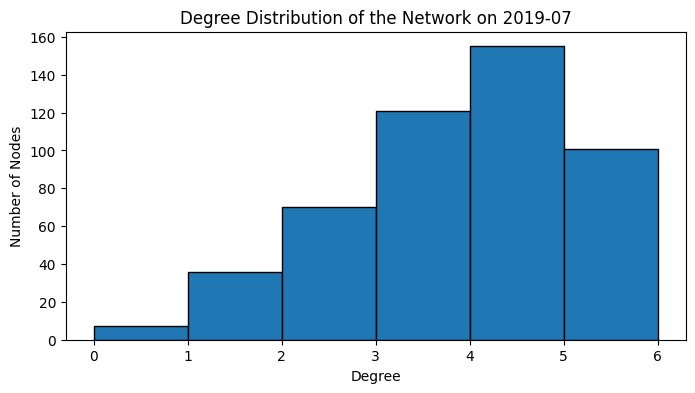

In [ ]:


degrees = [degree for node, degree in G.degree()]
avg_degree = sum(degrees) / G.number_of_nodes()
print("Average node degree:", avg_degree)
print("Distribution of node degrees:", degrees)
print("Number of components:", nx.number_connected_components(G))

print("Number of edges:", G.number_of_edges())

plt.hist(degrees, bins=range(0, max(degrees) +2 ), edgecolor='black')

plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution of the Network on " + date)
plt.show()

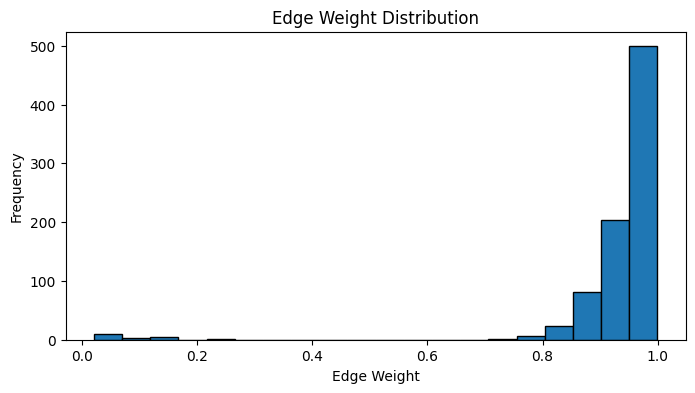

In [ ]:

edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]
plt.hist(edge_weights, bins=20, edgecolor='black')
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.title("Edge Weight Distribution")
plt.show()

In [11]:
density = nx.density(G)
print("Graph density:", density)

Graph density: 0.007147582106990369


In [12]:
avg_clustering_coefficient = nx.average_clustering(G)
print("Average clustering coefficient:", avg_clustering_coefficient)

Average clustering coefficient: 0.1884057971014494


In [59]:
# Calculate the mean, std, min, max edge count for the network

edge_count = []  
graph_count = 0


for key in all_edges_dict.keys():
    local_dict = all_edges_dict[key]
    edge_count.append(len(local_dict.keys()))
    graph_count += 1


std_edge = np.std(edge_count)
mean_edge_count = sum(edge_count) / graph_count
print("Mean edge count:", mean_edge_count)
print("Standard deviation of edge count:", std_edge)
print("Minimum edge count:", min(edge_count))
print("Maximum edge count:", max(edge_count))




Mean edge count: 1745.564595314911
Standard deviation of edge count: 197.85208677222965
Minimum edge count: 1069
Maximum edge count: 1977


In [53]:
local_dict

{('FI', 'FISV'): {'correlation': 1.0},
 ('CBS', 'PARA'): {'correlation': 0.9999999989874349},
 ('PKI', 'RVTY'): {'correlation': 0.999999997960755},
 ('ABC', 'COR'): {'correlation': 0.9999999836282406},
 ('GEN', 'NLOK'): {'correlation': 0.9999999780418272},
 ('IAC', 'MTCH'): {'correlation': 0.9999999095213133},
 ('COG', 'CTRA'): {'correlation': 0.9999998929519358},
 ('DD', 'DWDP'): {'correlation': 0.9999971545017887},
 ('RTX', 'UTX'): {'correlation': 0.9999613045793547},
 ('CTL', 'LUMN'): {'correlation': 0.9998892231395456},
 ('PARA', 'VIAC'): {'correlation': 0.9994550284577703},
 ('CBS', 'VIAC'): {'correlation': 0.9994545943204539},
 ('LHX', 'USB'): {'correlation': 0.9911211584666708},
 ('BEN', 'WFC'): {'correlation': 0.9896506421495341},
 ('IBM', 'ORCL'): {'correlation': 0.9890448582812362},
 ('CSCO', 'IBM'): {'correlation': 0.9884452731640331},
 ('BAC', 'WFC'): {'correlation': 0.9869789336722985},
 ('CSCO', 'USB'): {'correlation': 0.9859538992713991},
 ('USB', 'WMB'): {'correlation':